# Goals

From dataset of Portuguese Tweets annotated as Neutral, Positive and Negative sentiment by hand, apply an EDA to find insights.

One problematic is that I don t speak protuguese thus I can t read the data on my own and start with some assumptions or considerations about it. However I can assume that I am in a context of classification so I want to know what will be a good methodology for building a model (or a product) with that data.

# Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
stopwords = stopwords.words('portuguese')

import re

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import gensim
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim


from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, ComplementNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from wordcloud import WordCloud


# Utilities

In [2]:
def clean_text(text, stopwords):
    
    text = text.lower()
    
    text = re.sub(r'@\w*\s?', '', text)
    text = re.sub(r'#\w*\s?', '', text)
    text = re.sub(r'(http://t.co/)\w{10}', '', text)
    
    if not stopwords is None:
        text = ' '.join([w for w in text.split(' ') if not w in stopwords])
    
    text = re.sub(r'[^\w\s]', ' ', text)
    
    text = re.sub(r'\s+', ' ', text)
    
    text = re.sub(r'\d', '', text)
    
    text = re.sub('rt', '', text)
    
    text = text.strip()
    
    return text


def show_wordcloud(data):
    
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()
    
    
def get_top_n_ngram(corpus, ngram, n):
    
    vec = CountVectorizer(ngram_range=ngram, max_df=0.95, min_df=3).fit(corpus)
    
    bag_of_words = vec.transform(corpus)
    
    sum_words = bag_of_words.sum(axis=0)

    
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]


def Jaccard_Similarity(doc1, doc2): 
    
    words_doc1 = set(doc1) 
    words_doc2 = set(doc2)
    
    intersection = words_doc1.intersection(words_doc2)

    union = words_doc1.union(words_doc2)
 
    return float(len(intersection)) / len(union)


def lda_corpus_per_category(df, category):
    if category=='Full':
        lda_corpus = df.clean_text.apply(lambda t: t.split(' ')).tolist()
    else:
        lda_corpus = df[df.HandLabel==category].clean_text.apply(lambda t: t.split(' ')).tolist()
    dictionary = gensim.corpora.Dictionary(lda_corpus)
    bow_corpus = [dictionary.doc2bow(doc) for doc in lda_corpus]
    
    return lda_corpus, dictionary, bow_corpus


def lda_run_model(k, bow_corpus, dictionary):
    lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics = k, id2word = dictionary)
    return lda_model


def lda_coherence(lda_model, lda_corpus, dictionary):
    coherence_model_lda = CoherenceModel(model=lda_model, texts=lda_corpus, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    return coherence_lda

# Data

In [3]:
df1 = pd.read_excel('Portuguese_tweets_with_text_1.xlsx', index_col=0)
df2 = pd.read_excel('Portuguese_tweets_with_text_2.xlsx', index_col=0)
df =  pd.concat([df1, df2])

In [5]:
df.isnull().sum().sum()

0

In [4]:
df.TweetID.unique().shape[0] == df.shape[0]

True

In [5]:
df.AnnotatorID.unique().shape[0] == 1

True

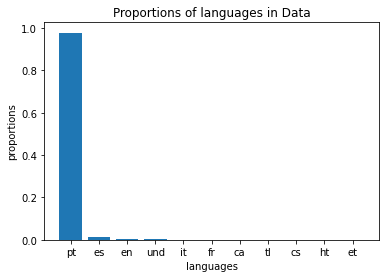

In [6]:
s = df.lang.value_counts(normalize=True)
plt.bar(s.index, s.values)
plt.xlabel('languages')
plt.ylabel('proportions')
plt.title('Proportions of languages in Data')
plt.show()


The data doesn't have any null values and duplicates but a small amount of languages different from portuguese appeared, so I keep only the portuguese and for future purposes I apply some transformation on the text.

In [9]:
df = df[df.lang=='pt'][['HandLabel', 'text']]

In [10]:
df['lower_text'] = df.text.apply(lambda t: t.lower())

In [11]:
df['len_text'] = df.text.apply(lambda t: len(t.split(' ')))

In [12]:
df['pre_text'] = df.text.apply(lambda t: clean_text(t, None))

1. len_text is the length of the original text
2. lower_text is the original text but only in lower case
3. pre_text is the original text cleaned but with the stopwords

# TEXT Analysis - EDA

## Random texts

In [7]:
df[df.HandLabel=='Neutral'].sample(n=5).text.tolist()

['ia à rua com o cão, mas já só tenho tempo de fazer a mala e pentear. sorry dog',
 'A Syone marcou presença na Red Hat Partner Conference e obtém reconhecimento internacional pioneiro em OpenStack!... http://t.co/RfYbHxGyyb',
 'Embaixadora da Suécia em Moçambique preocupada com corrupção http://t.co/iV9HNWO7wQ',
 '@Rui_JTC há quem o diga..',
 'Não estou mesmo habituada a ter aulas de manha, passo o dia todo cheia de sono deite-me cedo ou tarde.']

In [ ]:
df[df.HandLabel=='Negative'].sample(n=5).text.tolist()

In [ ]:
df[df.HandLabel=='Positive'].sample(n=5).text.tolist()

## Length of texts

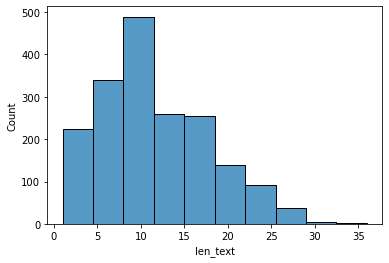

In [13]:
sns.histplot(df, x='len_text', bins=10)
plt.show()

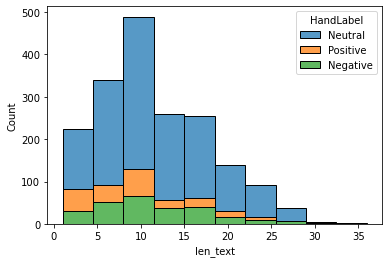

In [14]:
sns.histplot(df, x='len_text', hue='HandLabel', multiple='stack', bins=10)
plt.show()

In [15]:
df.groupby('HandLabel').len_text.describe()

,count,mean,std,min,25%,50%,75%,max
HandLabel,,,,,,,,
Negative,257.0,11.066148,6.049882,1.0,6.0,10.0,15.0,29.0
Neutral,1367.0,11.806876,6.201179,1.0,7.0,11.0,16.0,36.0
Positive,219.0,9.296804,5.746043,1.0,5.0,8.0,12.0,25.0


In first lecture we see that the lenggth of text is not a discriminant feature to help classifiy the sentiment.

## N grams Analysis

### StopWords

In [16]:
cw = get_top_n_ngram(df.pre_text.tolist(),(1,1), None)
df_cw = pd.DataFrame(cw, columns = ['text' , 'count'])

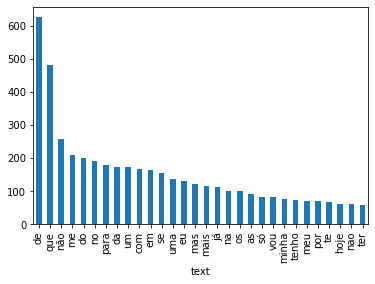

In [17]:
df_cw[:30].groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar')
plt.show()

In [18]:
cw_stopwords = df_cw.sort_values(by='count', ascending=False).text.tolist()[:200]

In [19]:
cw_stopwords[:50]

['de',
 'que',
 'não',
 'me',
 'do',
 'no',
 'para',
 'da',
 'um',
 'com',
 'em',
 'se',
 'uma',
 'eu',
 'mas',
 'mais',
 'já',
 'na',
 'os',
 'as',
 'só',
 'vou',
 'minha',
 'tenho',
 'meu',
 'por',
 'te',
 'hoje',
 'nao',
 'ter',
 'mesmo',
 'ao',
 'quando',
 'ser',
 'como',
 'dia',
 'ou',
 'pessoas',
 'fazer',
 'estou',
 'está',
 'dos',
 'há',
 'nada',
 'nem',
 'muito',
 'tem',
 'agora',
 'vai',
 'bem']

In [20]:
len(stopwords), stopwords

(204,
 ['de',
  'a',
  'o',
  'que',
  'e',
  'é',
  'do',
  'da',
  'em',
  'um',
  'para',
  'com',
  'não',
  'uma',
  'os',
  'no',
  'se',
  'na',
  'por',
  'mais',
  'as',
  'dos',
  'como',
  'mas',
  'ao',
  'ele',
  'das',
  'à',
  'seu',
  'sua',
  'ou',
  'quando',
  'muito',
  'nos',
  'já',
  'eu',
  'também',
  'só',
  'pelo',
  'pela',
  'até',
  'isso',
  'ela',
  'entre',
  'depois',
  'sem',
  'mesmo',
  'aos',
  'seus',
  'quem',
  'nas',
  'me',
  'esse',
  'eles',
  'você',
  'essa',
  'num',
  'nem',
  'suas',
  'meu',
  'às',
  'minha',
  'numa',
  'pelos',
  'elas',
  'qual',
  'nós',
  'lhe',
  'deles',
  'essas',
  'esses',
  'pelas',
  'este',
  'dele',
  'tu',
  'te',
  'vocês',
  'vos',
  'lhes',
  'meus',
  'minhas',
  'teu',
  'tua',
  'teus',
  'tuas',
  'nosso',
  'nossa',
  'nossos',
  'nossas',
  'dela',
  'delas',
  'esta',
  'estes',
  'estas',
  'aquele',
  'aquela',
  'aqueles',
  'aquelas',
  'isto',
  'aquilo',
  'estou',
  'está',
  'estamos',

We can use a count vectorizer on the pre text to extract waht seems to be stopwords (here cw_stopwords) however I don t konw portuguese thus i will keep the list of stopwords given by nltk package and use it to clean the text.

In [9]:
df['clean_text'] = df.text.apply(lambda t: clean_text(t, stopwords))

### Top Ngram Per Category

In [22]:
full_corpus = df.clean_text.tolist()
neutral_corpus = df[df.HandLabel=='Neutral'].clean_text.tolist()
pos_corpus = df[df.HandLabel=='Positive'].clean_text.tolist()
neg_corpus = df[df.HandLabel=='Negative'].clean_text.tolist()

CORPUS = {
    'full': full_corpus,
    'neutral': neutral_corpus,
    'negative': neg_corpus,
    'positive': pos_corpus
}

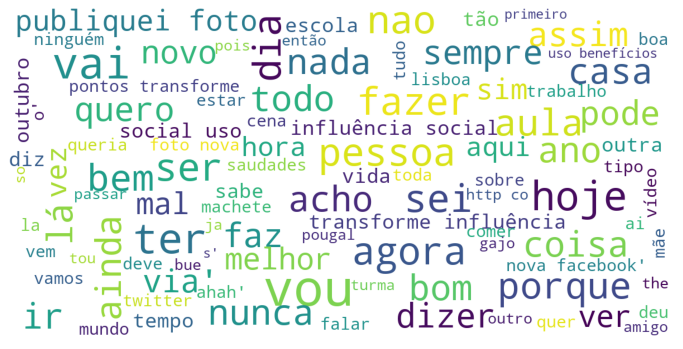

In [23]:
show_wordcloud(CORPUS['neutral'])

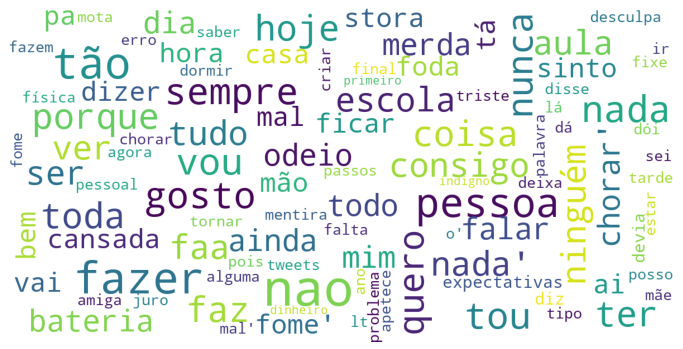

In [24]:
show_wordcloud(CORPUS['negative'])

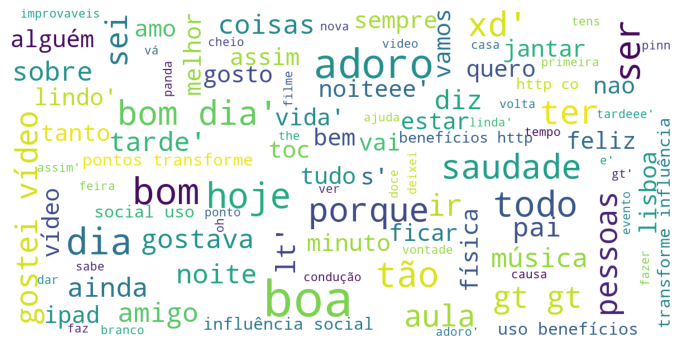

In [25]:
show_wordcloud(CORPUS['positive'])

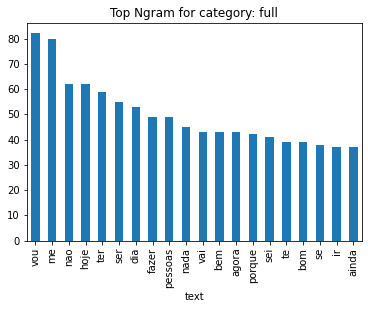

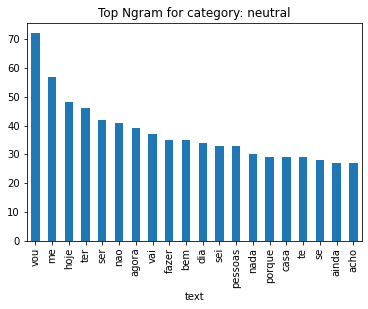

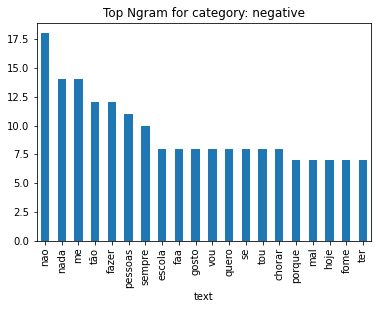

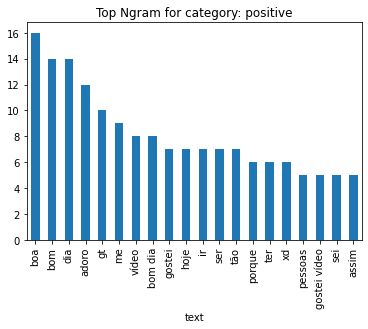

In [26]:
BOW = {}
for name, corpus in CORPUS.items():
    cw = get_top_n_ngram(corpus,(1,3), None)
    df_cw = pd.DataFrame(cw, columns = ['text' , 'count'])
    BOW[name] = df_cw.text.tolist()

    df_cw[:20].groupby('text').sum()['count'].sort_values(ascending=False).plot(kind='bar', title='Top Ngram for category: '+name)
    plt.show()

We can easily identify the top grams per sentiment.

### Overlapp - Jaccard

In [27]:
J = np.zeros((4,4))
names = list(BOW.keys())

for i, name in enumerate(names):
    doci = BOW[name]
    for j, name in enumerate(names):
        docj = BOW[name]
        J[i,j] = Jaccard_Similarity(doci, docj)

In [28]:
df_jaccard = pd.DataFrame(data=J, index=names, columns=names)

In [29]:
df_jaccard

,full,neutral,negative,positive
full,1.000000,0.750499,0.094810,0.081836
neutral,0.750499,1.000000,0.108639,0.100264
negative,0.094810,0.108639,1.000000,0.180000
positive,0.081836,0.100264,0.180000,1.000000


The Jaccard Similiraty allow us to quantify the overlap in terms of vocabulary, of the sentiment in the data. We see few things:
1. Negative / Positive got 18% of similarity
2. duo Negative / Neutral and Positive / Neutral share 10% of similarity

We have here overlap that may conduct to rise false predictions.

### Comfort with Bayesian Model

In [30]:
X = CORPUS['full']
y = df.HandLabel.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y)

vec = TfidfVectorizer(ngram_range=(1,3), max_df=0.95, min_df=3)
M_train = vec.fit_transform(X_train).toarray()
M_test = vec.transform(X_test).toarray()


clf =  ComplementNB().fit(M_train, y_train)
y_pred = clf.predict(M_test)

print(M_train.shape)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))

(1382, 722)
Accuracy: 0.5379609544468547
F1 score: 0.4349585406301824
              precision    recall  f1-score   support

    Negative       0.21      0.44      0.28        64
     Neutral       0.80      0.57      0.67       342
    Positive       0.30      0.44      0.36        55

    accuracy                           0.54       461
   macro avg       0.44      0.48      0.43       461
weighted avg       0.66      0.54      0.58       461



A Bayesian model to predict between Neutral / Negative / Positive is not suitable for that data -  we remark the difficulty for the model to understand between Neutral and Positive or Negative.

In [31]:
X = df[df.HandLabel.isin(['Positive', 'Negative'])].clean_text.tolist()
y = df[df.HandLabel.isin(['Positive', 'Negative'])].HandLabel.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

vec = TfidfVectorizer(ngram_range=(1,3), max_df=0.9, min_df=2)
M_train = vec.fit_transform(X_train).toarray()
M_test = vec.transform(X_test).toarray()


clf =  ComplementNB().fit(M_train, y_train)
y_pred = clf.predict(M_test)

print(M_train.shape)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 score:', f1_score(y_test, y_pred, average="macro"))
print(classification_report(y_test, y_pred))

(380, 348)
Accuracy: 0.7395833333333334
F1 score: 0.7311526828721855
              precision    recall  f1-score   support

    Negative       0.72      0.85      0.78        52
    Positive       0.77      0.61      0.68        44

    accuracy                           0.74        96
   macro avg       0.75      0.73      0.73        96
weighted avg       0.74      0.74      0.74        96



Now if we focus only on Negative or Positive we obtain a better result however, the dataset is small and I don t think we improve the model a lot -  we need to use transformer that can extract the sentiment better.

### Comfort With Pre Trained Transformer

https://www.kaggle.com/code/viniciuscleves/sentiment-analysis-on-tweets-in-portuguese

## LDA for Topic Modelling Per Category

We want to look more generally to the full corpus and look for what kind of subjects the peolpe are talking about.

What subjects support the sentiments ?

I use Latent Dirichlet Allocation to extract the topics but I also use the Coherence metric to find the best number of subject in the data.

### Full

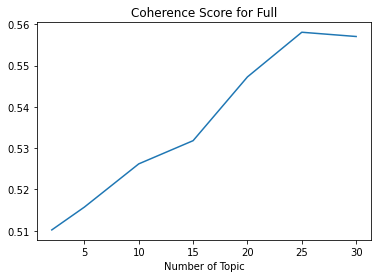

In [41]:
lda_corpus, dictionary, bow_corpus = lda_corpus_per_category(df, 'Full')
coherence_scores = []
ks = [2,5,10,15,20,25,30]
for k in ks:
    lda_model = lda_run_model(k, bow_corpus, dictionary)

    coherence_lda = lda_coherence(lda_model, lda_corpus, dictionary)
    
    coherence_scores.append(coherence_lda)

plt.plot(ks, coherence_scores)
plt.title('Coherence Score for Full')
plt.xlabel('Number of Topic')
plt.show()

For the entire corpus, we remark that many topics may be present is the data

### Neutral

In [10]:
lda_corpus, dictionary, bow_corpus = lda_corpus_per_category(df, 'Neutral')

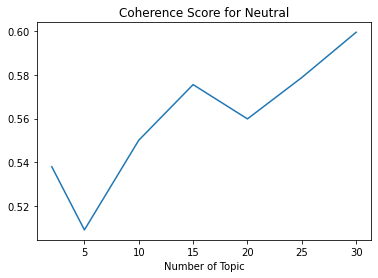

In [11]:
coherence_scores = []
ks = [2,5,10,15,20,25,30]
for k in ks:
    lda_model = lda_run_model(k, bow_corpus, dictionary)

    coherence_lda = lda_coherence(lda_model, lda_corpus, dictionary)
    
    coherence_scores.append(coherence_lda)

plt.plot(ks, coherence_scores)
plt.title('Coherence Score for Neutral')
plt.xlabel('Number of Topic')
plt.show()

In [12]:
lda_model = lda_run_model(5, bow_corpus, dictionary)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.076066  0.073221       1        1  21.019113
3     -0.049439 -0.013614       2        1  20.519468
1      0.000563 -0.099998       3        1  20.185972
0     -0.090671  0.056764       4        1  19.511349
2      0.063481 -0.016373       5        1  18.764098, topic_info=          Term        Freq       Total Category  logprob  loglift
81              112.000000  112.000000  Default  30.0000  30.0000
82    facebook   17.000000   17.000000  Default  29.0000  29.0000
33         vou   50.000000   50.000000  Default  28.0000  28.0000
88   publiquei   13.000000   13.000000  Default  27.0000  27.0000
116        ter   32.000000   32.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
46       agora    6.007824   27.823303   Topic5  -5.6598   0.1404
33         vou    6.964986   50.760201   Topic5  -5.5120  -0.3130
457         lá    4.893108   17.916625   Topic5  -5.8650   0.3753
433        ver    4.680493   17.267358   Topic5  -5.9095   0.3678
81                5.712687  112.133334   Topic5  -5.7102  -1.3038

[368 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
81        1  0.214031       
81        2  0.249703       
81        3  0.098098       
81        4  0.392390       
81        5  0.053508       
...     ...       ...    ...
2671      1  0.721124  zhjaj
859       2  0.951720     às
248       3  0.208316      á
248       4  0.208316      á
248       5  0.624947      á

[654 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 4, 2, 1, 3])

### Positive

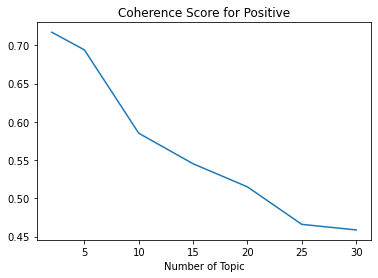

In [45]:
lda_corpus, dictionary, bow_corpus = lda_corpus_per_category(df, 'Positive')
coherence_scores = []
ks = [2,5,10,15,20,25,30]
for k in ks:
    lda_model = lda_run_model(k, bow_corpus, dictionary)

    coherence_lda = lda_coherence(lda_model, lda_corpus, dictionary)
    
    coherence_scores.append(coherence_lda)

plt.plot(ks, coherence_scores)
plt.title('Coherence Score for Positive')
plt.xlabel('Number of Topic')
plt.show()

In [46]:
lda_model = lda_run_model(5, bow_corpus, dictionary)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.123920 -0.015762       1        1  25.922035
4     -0.096310 -0.083765       2        1  23.268653
1      0.024925 -0.008123       3        1  19.296662
3     -0.049560  0.120026       4        1  18.496489
2     -0.002974 -0.012375       5        1  13.016162, topic_info=       Term       Freq      Total Category  logprob  loglift
194     boa   9.000000   9.000000  Default  30.0000  30.0000
155   adoro   7.000000   7.000000  Default  29.0000  29.0000
178      gt   6.000000   6.000000  Default  28.0000  28.0000
17           10.000000  10.000000  Default  27.0000  27.0000
460     toc   2.000000   2.000000  Default  26.0000  26.0000
..      ...        ...        ...      ...      ...      ...
351   quero   0.603234   2.374339   Topic5  -5.5549   0.6688
550   gosto   0.603159   2.312742   Topic5  -5.5550   0.6950
291  melhor   0.602874   2.824106   Topic5  -5.5555   0.4947
288     faz   0.602830   1.668003   Topic5  -5.5555   1.0212
36   evento   0.602702   1.667898   Topic5  -5.5558   1.0211

[287 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
17        2  0.285305         
17        3  0.095102         
17        4  0.380407         
17        5  0.190203         
670       5  0.917502  aceaste
...     ...       ...      ...
508       3  0.856561      zhj
471       2  0.420641        º
471       4  0.420641        º
763       4  0.858604    único
677       5  0.917444     útil

[329 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 2, 4, 3])

### Negative

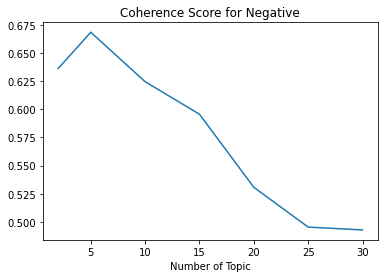

In [47]:
lda_corpus, dictionary, bow_corpus = lda_corpus_per_category(df, 'Negative')
coherence_scores = []
ks = [2,5,10,15,20,25,30]
for k in ks:
    lda_model = lda_run_model(k, bow_corpus, dictionary)

    coherence_lda = lda_coherence(lda_model, lda_corpus, dictionary)
    
    coherence_scores.append(coherence_lda)

plt.plot(ks, coherence_scores)
plt.title('Coherence Score for Negative')
plt.xlabel('Number of Topic')
plt.show()

In [48]:
lda_model = lda_run_model(5, bow_corpus, dictionary)
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4      0.119834 -0.029183       1        1  21.949084
1     -0.028702 -0.090429       2        1  20.698030
3     -0.087115 -0.019961       3        1  20.430767
2      0.017247  0.055326       4        1  18.794205
0     -0.021265  0.084247       5        1  18.127914, topic_info=        Term       Freq      Total Category  logprob  loglift
16       nao  11.000000  11.000000  Default  30.0000  30.0000
134     fome   4.000000   4.000000  Default  29.0000  29.0000
193  pessoas   7.000000   7.000000  Default  28.0000  28.0000
139    nunca   4.000000   4.000000  Default  27.0000  27.0000
28             7.000000   7.000000  Default  26.0000  26.0000
..       ...        ...        ...      ...      ...      ...
464      ser   1.308730   4.235834   Topic5  -5.4035   0.5332
135      tou   1.357696   5.427711   Topic5  -5.3667   0.3220
160    fazer   1.488367   7.887874   Topic5  -5.2749   0.0401
133      tão   1.386903   7.910417   Topic5  -5.3455  -0.0334
316   escola   1.311383   5.478923   Topic5  -5.4015   0.2779

[297 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
28        1  0.139131         
28        3  0.556523         
28        4  0.139131         
28        5  0.139131         
357       1  0.967589        a
...     ...       ...      ...
276       5  0.556016       vá
610       3  0.831147   várias
694       5  0.556036        x
620       3  0.831155        ª
1016      4  0.839187  últimos

[373 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])